In [265]:
# Import the necessary packages
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.python.framework.ops import EagerTensor
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

In [266]:
# Load the VGG19 network
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')
vgg.trainable = False

In [267]:
# Define the content cost
def content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]

    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=[m, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, -1, n_C])

    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))) / (4 * n_H * n_W * n_C)

    return J_content

In [268]:
# Define the gram matrix
def gram_matrix(A):
    gram_matrix = tf.matmul(A, tf.transpose(A))
    return gram_matrix

In [269]:
# Define the style cost
def layer_style_cost(a_S,a_G):
    m, n_H, n_w, n_C = a_S.get_shape().as_list()

    a_S_unrolled = tf.reshape(tf.transpose(tf.reshape(a_S, shape=[m, -1, n_C]),perm=[0,2,1]),shape=[n_C,-1])
    style_matrix = gram_matrix(a_S_unrolled)
    a_G_unrolled = tf.reshape(tf.transpose(tf.reshape(a_G, shape=[m, -1, n_C]),perm=[0,2,1]),shape=[n_C,-1])
    generated_matrix = gram_matrix(a_G_unrolled)
    J_style = tf.reduce_sum(tf.square(tf.subtract(style_matrix,generated_matrix)))/(4*(n_C**2)*(n_H*n_w)**2)

    return J_style

In [270]:
# Define the style layers and weights
STYLE_LAYERS = [
    ('block1_conv1', 1.0),
    ('block2_conv1', 0.8),
    ('block3_conv1', 0.7),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.1)]

# Define the style cost
def style_cost(style_image_output,generated_image_output,style_layers=STYLE_LAYERS):
    J_style = 0
    a_S = style_image_output[1:]
    a_G = generated_image_output[1:]
    for i,(layer_name,coeff) in enumerate(style_layers):
        J_style += coeff*layer_style_cost(a_S[i],a_G[i])
    return J_style

In [271]:
# Define the total cost
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J_total = alpha*J_content + beta*J_style
    return J_total

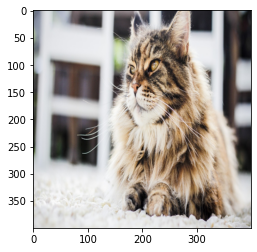

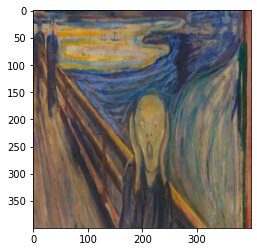

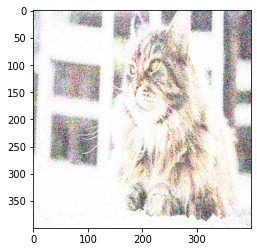

In [272]:
# Load the content image 
content_image = np.array(Image.open("persepolis.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))
imshow(content_image[0])
plt.show()

# Load the style image 
style_image =  np.array(Image.open("van_gogh.webp").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))
imshow(style_image[0])
plt.show()

# Create the generated image
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.8)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
imshow(generated_image.numpy()[0])
plt.show()

In [273]:
# Define a model which returns intermediate values
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [274]:
# Create the model
content_layer = [('block5_conv4', 1)]
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [275]:
# Preprocessing
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

# Get the hidden layer activations
a_C = vgg_model_outputs(preprocessed_content)
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = content_cost(a_C, a_G)
print(J_content)

tf.Tensor(0.009982582, shape=(), dtype=float32)


In [276]:
# Preprocessing
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)
# Compute the style cost
J_style = style_cost(a_S, a_G)
print(J_style)

tf.Tensor(2181.0996, shape=(), dtype=float32)


In [277]:
# To clip alll the values to under 1
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# To convert the tensors back to image
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [278]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

# Define the training step
generated_image = tf.Variable(tf.image.convert_image_dtype(generated_image, tf.float32))
@tf.function()
def train_step(generated_image, alpha = 10, beta = 40):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
        J_style = style_cost(a_S, a_G)
        J_content = content_cost(a_C, a_G)
        J = total_cost(J_content, J_style,alpha=alpha,beta=beta)
    grad = tape.gradient(J, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

Epoch:  0  J_total:  10905498.0


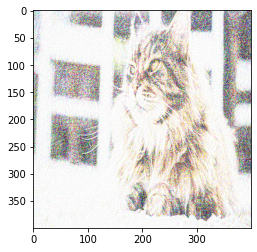

Epoch:  10  J_total:  871362.94


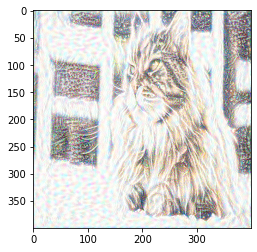

Epoch:  20  J_total:  376693.88


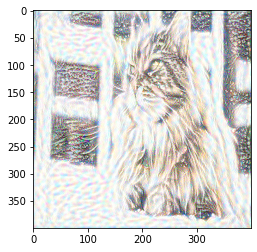

Epoch:  30  J_total:  208364.45


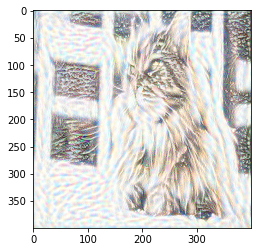

Epoch:  40  J_total:  129529.16


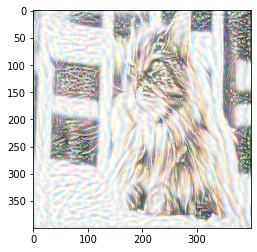

Epoch:  50  J_total:  89714.24


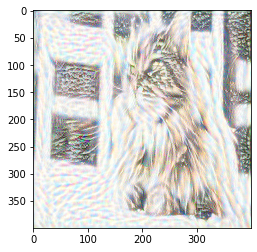

Epoch:  60  J_total:  67689.74


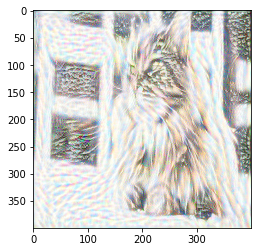

Epoch:  70  J_total:  54251.4


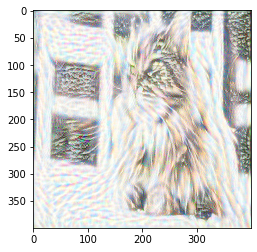

Epoch:  80  J_total:  45355.97


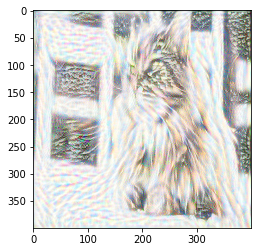

Epoch:  90  J_total:  39058.746


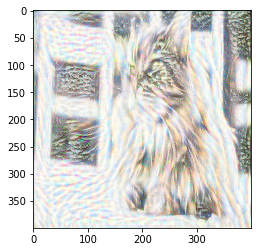

Epoch:  100  J_total:  34323.793


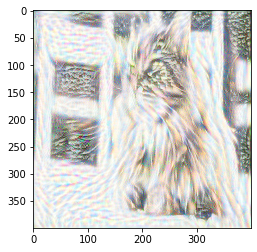

Epoch:  110  J_total:  30610.447


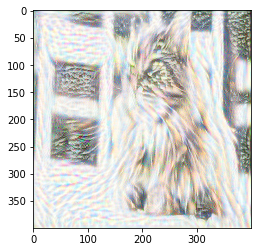

Epoch:  120  J_total:  27603.873


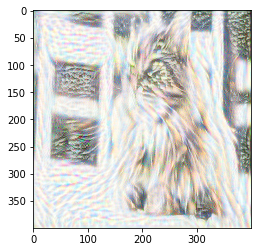

Epoch:  130  J_total:  25127.605


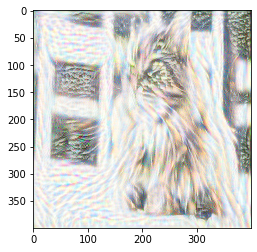

Epoch:  140  J_total:  23038.498


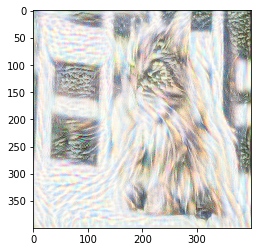

Epoch:  150  J_total:  21253.975


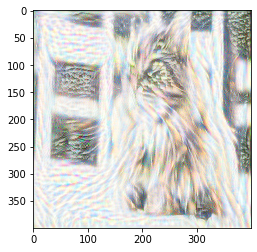

Epoch:  160  J_total:  19716.947


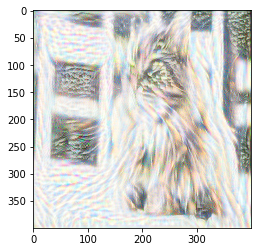

Epoch:  170  J_total:  18386.314


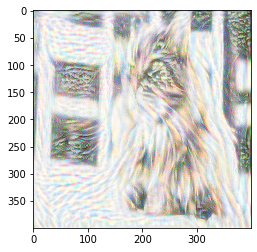

Epoch:  180  J_total:  17278.959


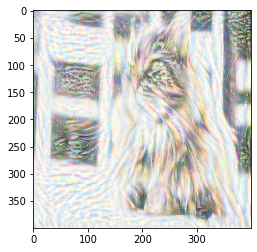

Epoch:  190  J_total:  18323.385


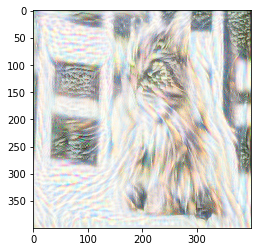

Epoch:  200  J_total:  18954.08


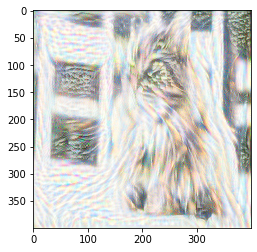

Epoch:  210  J_total:  15641.367


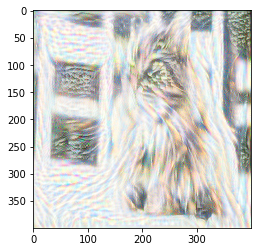

Epoch:  220  J_total:  14181.416


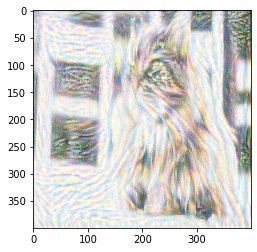

Epoch:  230  J_total:  13323.933


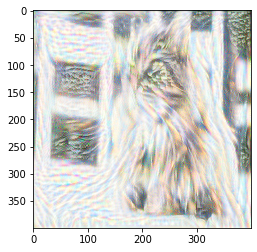

Epoch:  240  J_total:  12682.762


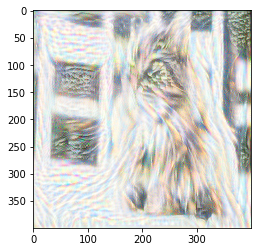

Epoch:  250  J_total:  12168.817


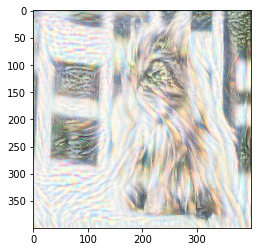

Epoch:  260  J_total:  13263.452


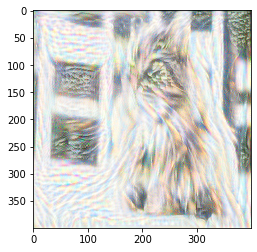

Epoch:  270  J_total:  11556.269


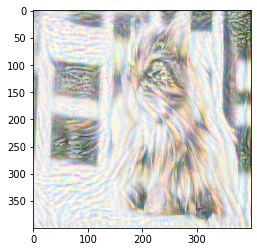

Epoch:  280  J_total:  10882.08


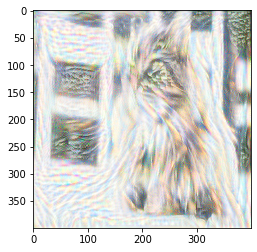

Epoch:  290  J_total:  10714.452


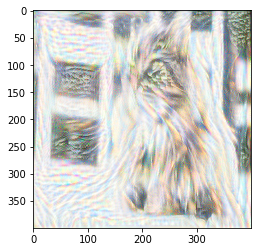

Epoch:  300  J_total:  10058.1875


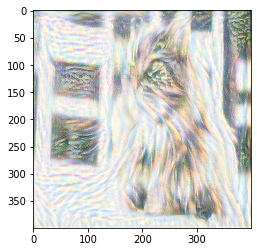

Epoch:  310  J_total:  22383.816


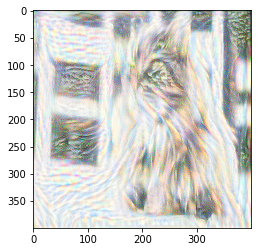

Epoch:  320  J_total:  2094715.2


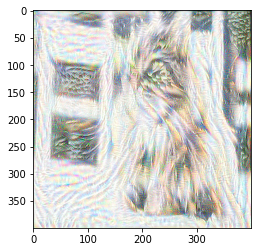

Epoch:  330  J_total:  277878.38


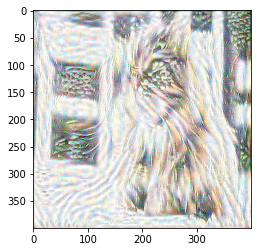

Epoch:  340  J_total:  110834.836


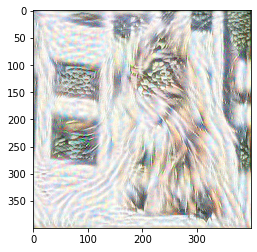

Epoch:  350  J_total:  58591.613


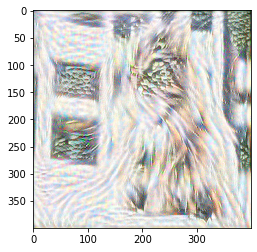

Epoch:  360  J_total:  36861.45


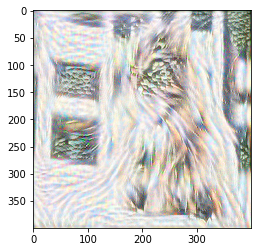

Epoch:  370  J_total:  26947.771


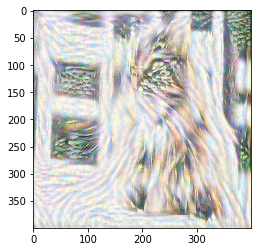

Epoch:  380  J_total:  21863.508


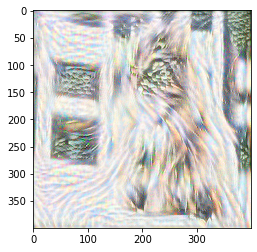

Epoch:  390  J_total:  18808.291


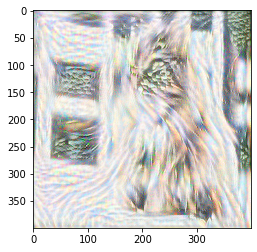

Epoch:  400  J_total:  16859.975


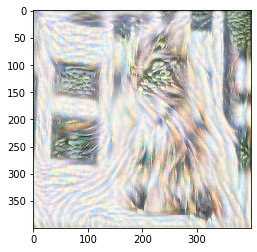

Epoch:  410  J_total:  15314.972


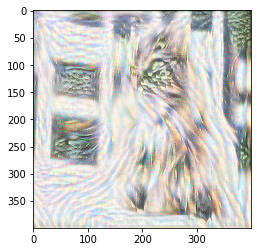

Epoch:  420  J_total:  15281.582


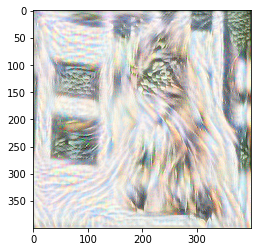

Epoch:  430  J_total:  14181.315


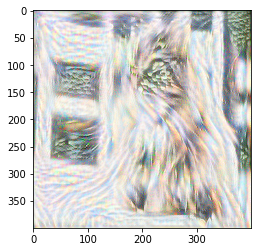

Epoch:  440  J_total:  12600.132


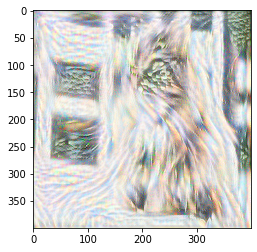

Epoch:  450  J_total:  12102.51


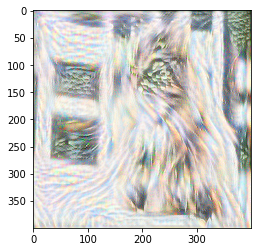

Epoch:  460  J_total:  11411.745


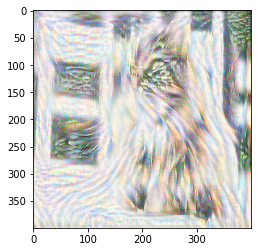

Epoch:  470  J_total:  11253.961


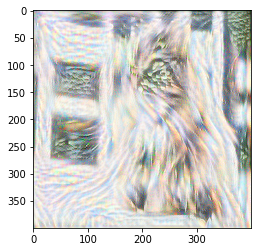

Epoch:  480  J_total:  10848.1875


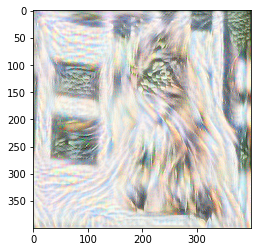

Epoch:  490  J_total:  10774.014


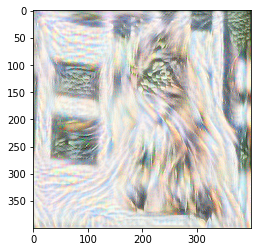

In [279]:
# Train the model
epochs = 100
cost = []
for i in range(epochs):
    J_total = train_step(generated_image)
    cost.append(J_total)
    if i%10 == 0:
        print("Epoch: ",i," J_total: ",J_total.numpy())
        imshow(generated_image.numpy()[0])
        plt.show()